In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize


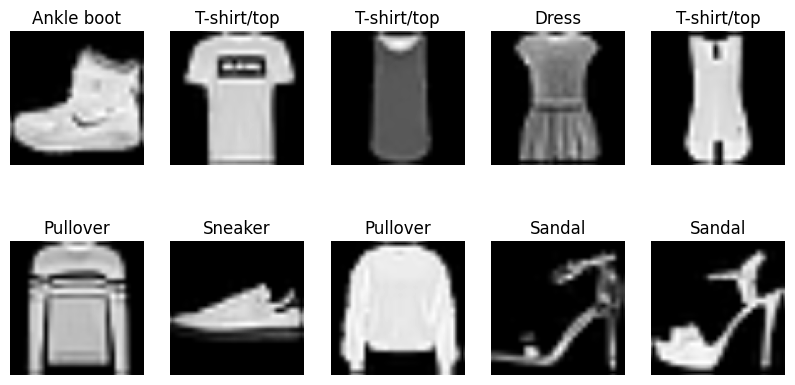

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

x_train_resized = np.array([resize(x, (80, 80)) for x in x_train])
x_test_resized = np.array([resize(x, (80, 80)) for x in x_test])

x_train_resized = x_train_resized / 255.0
x_test_resized = x_test_resized / 255.0

# Розширення кількості каналів до 3 (RGB)
x_train_rgb = np.repeat(x_train_resized[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test_resized[..., np.newaxis], 3, -1)

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_resized[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [4]:
# Завантаження моделі VGG16 без верхніх шарів та з замороженими вагами
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Змінено кількість вихідних класів

# Створення моделі
model = Model(inputs=base_model.input, outputs=predictions)

early_stopping_accuracy = EarlyStopping(monitor='val_accuracy',
                                        patience=10,
                                        restore_best_weights=True,
                                        verbose=1)

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [ ]:
# Аугментація даних
datagen_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

datagen_train.fit(x_train_rgb)

# Для валідаційних даних
datagen_valid = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

datagen_valid.fit(x_test_rgb)

history = model.fit(datagen_train.flow(x_train_rgb, y_train_one_hot, batch_size=128),
                    epochs=50,
                    validation_data=datagen_valid.flow(x_test_rgb, y_test_one_hot, batch_size=128),
                    callbacks=[early_stopping_accuracy])

Epoch 1/50
469/469 [==============================] - 2255s 5s/step - loss: 0.5736 - accuracy: 0.7926 - val_loss: 0.4588 - val_accuracy: 0.8302
Epoch 2/50
469/469 [==============================] - 2244s 5s/step - loss: 0.4643 - accuracy: 0.8308 - val_loss: 0.4353 - val_accuracy: 0.8413
Epoch 3/50
469/469 [==============================] - 2234s 5s/step - loss: 0.4328 - accuracy: 0.8415 - val_loss: 0.4335 - val_accuracy: 0.8417
Epoch 4/50
469/469 [==============================] - 2239s 5s/step - loss: 0.4137 - accuracy: 0.8478 - val_loss: 0.4509 - val_accuracy: 0.8262
Epoch 5/50
469/469 [==============================] - 2221s 5s/step - loss: 0.4020 - accuracy: 0.8524 - val_loss: 0.3930 - val_accuracy: 0.8553
Epoch 6/50
469/469 [==============================] - 2218s 5s/step - loss: 0.3851 - accuracy: 0.8583 - val_loss: 0.4317 - val_accuracy: 0.8428
Epoch 7/50
302/469 [==================>...........] - ETA: 11:18 - loss: 0.3785 - accuracy: 0.8599

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_rgb, y_test_one_hot, verbose=2)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss:", test_loss)

## Висновок

Згорткова мережа на основі VGG16 може бути більш ефективною для завдань обробки зображень завдяки попередньо навченій моделі, але може бути складнішою для розуміння та конфігурування. Вимагає більше часу для навчання моделі та більше ресурсів. Не дала покращення результатів навчання модеі порівнянно з багатошаровою моделлю.